### 1. Outline the Analysis Steps:
- We’ll import libraries, load the data, and visualize it.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
# import tensorflow as tf
# from keras.layers import LSTM
current_dir = os.getcwd()
# Append the parent directory to sys.path
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
# ignore warrnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
from scripts.model_development import ModelBuilder
from scripts.Data_extract import WorldDataAnalysis

In [ ]:
data_extracter =WorldDataAnalysis()

In [ ]:
data_extracter.fetch_world_data()

In [ ]:
data_extracter.resample_to_daily()

In [ ]:
file_path ='../data/BrentOilPrices.csv'
data_extracter.load_oil_prices_from_csv(file_path=file_path)

In [ ]:
data_extracter.merge_data()

In [ ]:
merged_data =pd.read_csv('merged_data.csv')
merged_data.head()

In [ ]:
merged_data.isnull().sum()

In [ ]:
# Check for missing values and data types
print(merged_data.info())
print(merged_data.describe())

In [ ]:
data =merged_data.drop(columns=['Exchange Rate (USD)'])
data.dropna(inplace=True)
data

### Exploratory Data Analysis (EDA)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(merged_data.index, merged_data['Price'], color='blue')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show()

#### Correlation Analysis

In [21]:
data_extracter.calculate_correlations()

NameError: name 'data_extracter' is not defined

In [10]:
data_extracter.specific_correlation(indicator1='GDP Growth (%)', indicator2='Price')

Correlation between GDP Growth (%) and Price: 0.04627042128070437


#### Analyze Potential Factors Influencing Oil Prices

Economic Indicators (GDP Growth, Inflation, Unemployment, Exchange Rate)

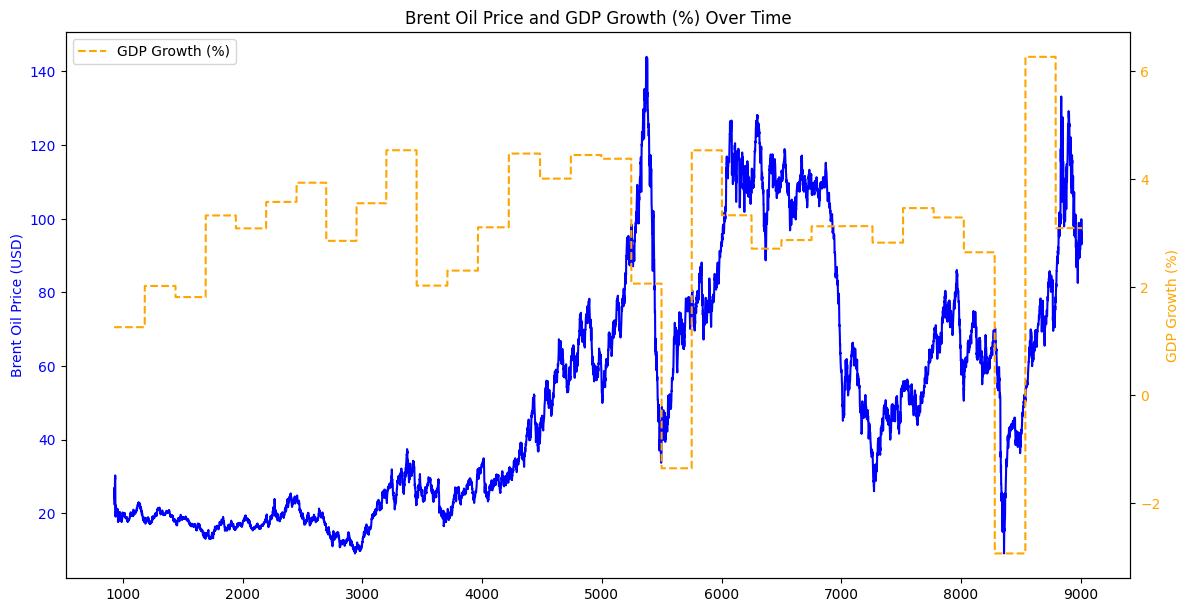

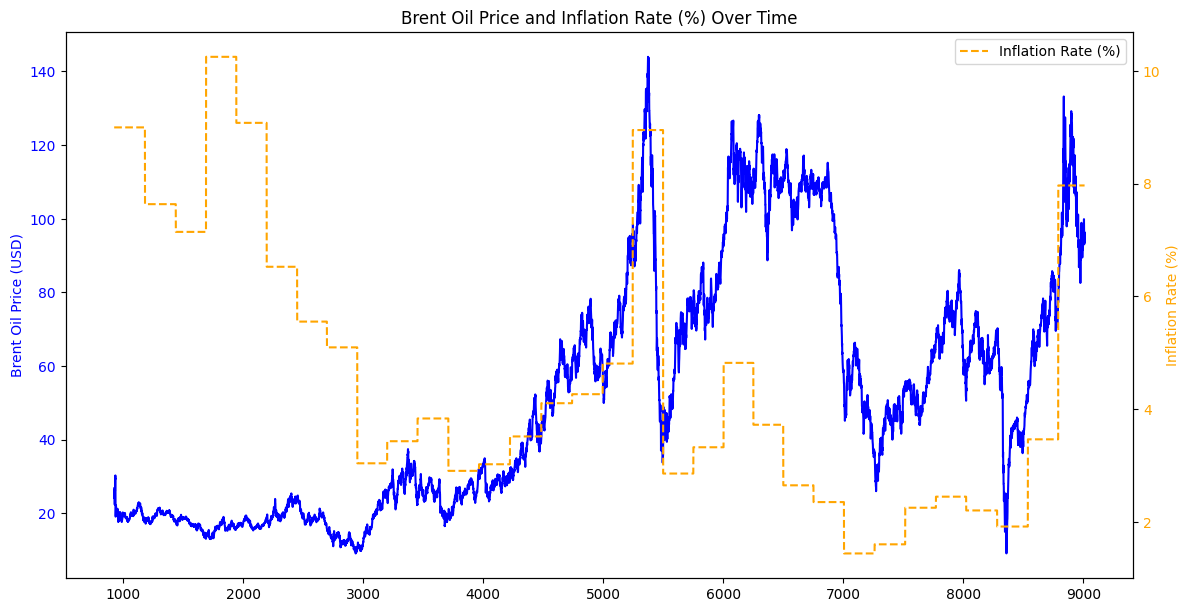

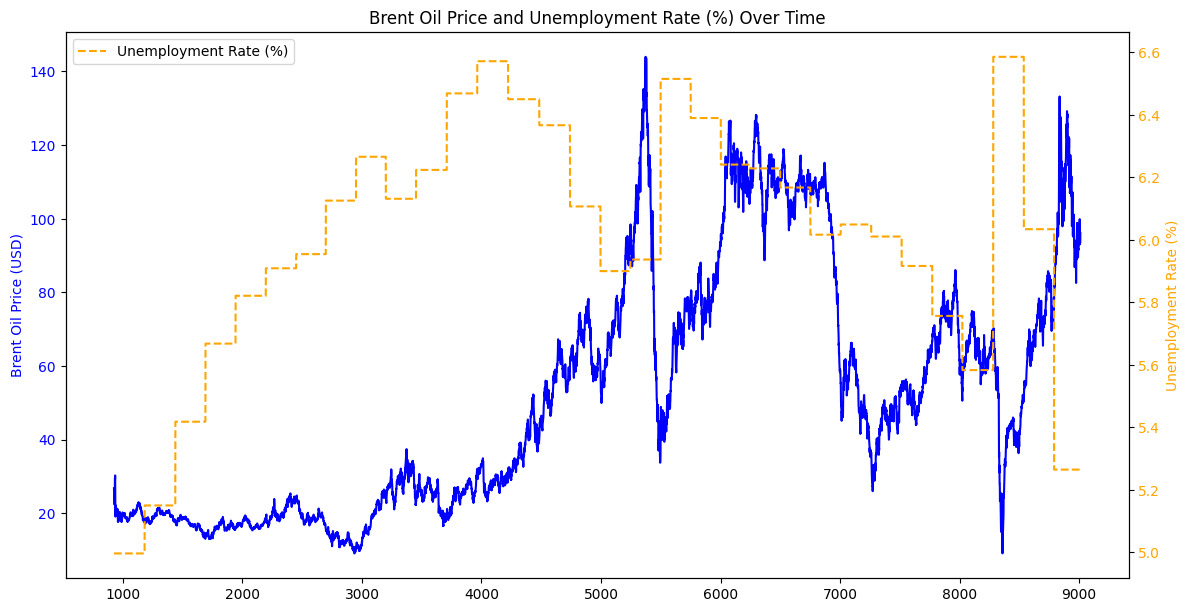

In [35]:
# Example plots for economic indicators against oil prices
for column in ['GDP Growth (%)', 'Inflation Rate (%)', 'Unemployment Rate (%)']:
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    ax1.plot(data.index, data['Price'], color='blue', label='Brent Oil Price')
    ax1.set_ylabel('Brent Oil Price (USD)', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(data.index, data[column], color='orange', linestyle='--', label=column)
    ax2.set_ylabel(column, color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    
    fig.tight_layout()
    plt.title(f"Brent Oil Price and {column} Over Time")
    plt.legend()
    plt.show()


### 2. Stationarity Check:
- Check if the data is stationary using the Augmented Dickey-Fuller (ADF) test, which is necessary for ARIMA.

##### Before applying any statistical model on a Time Series, the series has to be staionary, which means that, over different time periods:-

- **a)** It should have constant mean.
- **b)** It should have constant variance or standard deviation.
- **c)** Auto-covariance should not depend on time.

2024-11-01 15:14:11,560 - INFO - Performing Augmented Dickey-Fuller test for stationarity.
2024-11-01 15:14:12,485 - INFO - ADF Statistic: -1.9938560113924675
2024-11-01 15:14:12,486 - INFO - p-value: 0.28927350489340287
2024-11-01 15:14:12,487 - INFO - Data is non-stationary; applying first differencing.


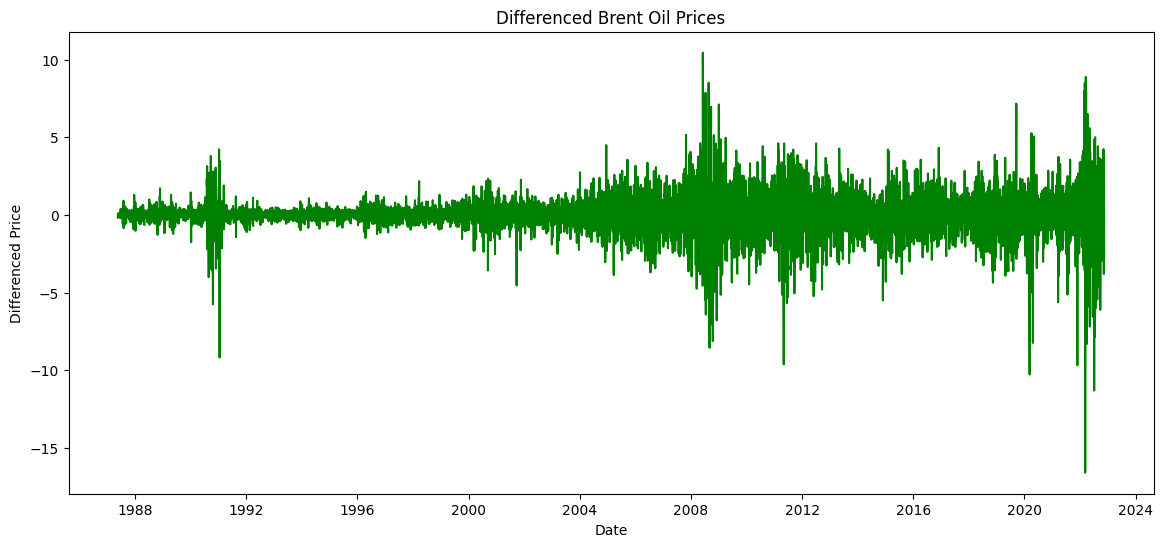

In [11]:
processor.check_stationarity()

### 2. Advanced Time Series Modeling

In [ ]:
model_builder = ModelBuilder()

#### Data Spliting

In [38]:
# Split data into 80% train and 20% test sets
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

##### Vector Autoregression (VAR) Model

In [49]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Define ADF test function
def adf_test(series):
    result = adfuller(series)
    return {'ADF Statistic': result[0], 'p-value': result[1]}

# Check for stationarity and difference if necessary
stationary_data = pd.DataFrame()
for column in data.columns:
    series = data[column].dropna()
    adf_result = adf_test(series)
    
    if adf_result['p-value'] > 0.05:
        print(f"{column} is non-stationary (p-value: {adf_result['p-value']}). Differencing applied.")
        stationary_data[column] = series.diff().dropna()
    else:
        print(f"{column} is stationary (p-value: {adf_result['p-value']}). No differencing applied.")
        stationary_data[column] = series
        

Date is non-stationary (p-value: 0.9984212758998687). Differencing applied.
GDP Growth (%) is stationary (p-value: 0.00044350495705694455). No differencing applied.
Inflation Rate (%) is non-stationary (p-value: 0.16760008947714272). Differencing applied.
Unemployment Rate (%) is non-stationary (p-value: 0.11545672194916429). Differencing applied.
Price is non-stationary (p-value: 0.2859021858697546). Differencing applied.


In [53]:
# Convert all columns to numeric (in case of any mixed types)
stationary_data = stationary_data.apply(pd.to_numeric, errors='coerce')

# Handle any remaining NaN values (e.g., by forward filling)
stationary_data = stationary_data.fillna(method='ffill').dropna()

# Splitting the data into train and test sets
train_size = int(0.8 * len(stationary_data))
train_data = stationary_data[:train_size]
test_data = stationary_data[train_size:]

# Ensure all columns are numeric and free from NaN in train_data
train_data = train_data.dropna()

# Fit the VAR model on the training data
model = VAR(train_data)
results = model.fit(maxlags=15, ic='aic')

# Forecasting
lag_order = results.k_ar
forecast_input = train_data.values[-lag_order:]
forecasted_values = results.forecast(y=forecast_input, steps=len(test_data))

# Convert forecasts to DataFrame for easy handling
forecast_df = pd.DataFrame(forecasted_values, index=test_data.index, columns=test_data.columns)

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [52]:
# Calculate RMSE and MAE for numeric columns only, excluding 'Date'
metrics = {
    'RMSE': {},
    'MAE': {}
}

# Filter out the non-numeric columns (like 'Date')
for column in test_data.columns:
    if pd.api.types.is_numeric_dtype(test_data[column]) and column != 'Date':
        actual = test_data[column]
        forecast = forecast_df[column]
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        # Store metrics
        metrics['RMSE'][column] = rmse
        metrics['MAE'][column] = mae

# Calculate aggregate metrics
aggregate_rmse = np.sqrt(np.mean([value**2 for value in metrics['RMSE'].values()]))
aggregate_mae = np.mean(list(metrics['MAE'].values()))

# Display the metrics summary
print("\nModel Performance Metrics:")
for metric, values in metrics.items():
    print(f"{metric}:")
    for key, value in values.items():
        print(f"  {key}: {value:.4f}")

# Display aggregate metrics
print(f"\nAggregate RMSE: {aggregate_rmse:.4f}")
print(f"Aggregate MAE: {aggregate_mae:.4f}")


Model Performance Metrics:
RMSE:
  GDP Growth (%): 2.6768
  Inflation Rate (%): 0.1199
  Unemployment Rate (%): 0.0349
  Price: 1.7544
MAE:
  GDP Growth (%): 1.7372
  Inflation Rate (%): 0.0050
  Unemployment Rate (%): 0.0018
  Price: 1.1590

Aggregate RMSE: 1.6015
Aggregate MAE: 0.7257


In [56]:
from statsmodels.tsa.arima.model import ARIMA
# Splitting the data into training and test sets
train_size = int(len(stationary_data) * 0.8)  # 80% training data
train_series = stationary_data['Price'][:train_size]  # Adjust 'Price' based on your DataFrame's column name
test_series = stationary_data['Price'][train_size:]

# Fit the ARIMA model
p, d, q = 1, 0, 1  # Set the appropriate values for ARIMA parameters
arima_model = ARIMA(train_series, order=(p, d, q))
arima_model_fitted = arima_model.fit()

# Forecast
forecast_steps = len(test_series)
pred = arima_model_fitted.forecast(steps=forecast_steps)

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test_series, pred))
mae = mean_absolute_error(test_series, pred)

# Output results
print("ARIMA Model RMSE:", rmse)
print("ARIMA Model MAE:", mae)

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates

ARIMA Model RMSE: 1.7543377827211946
ARIMA Model MAE: 1.1589707172196293


e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Time Series Modeling - ARIMA

e:\Kiffya_10_acc\Week 10\Brent-Oil-Impact-Analysis-and-Price-Forecasting\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


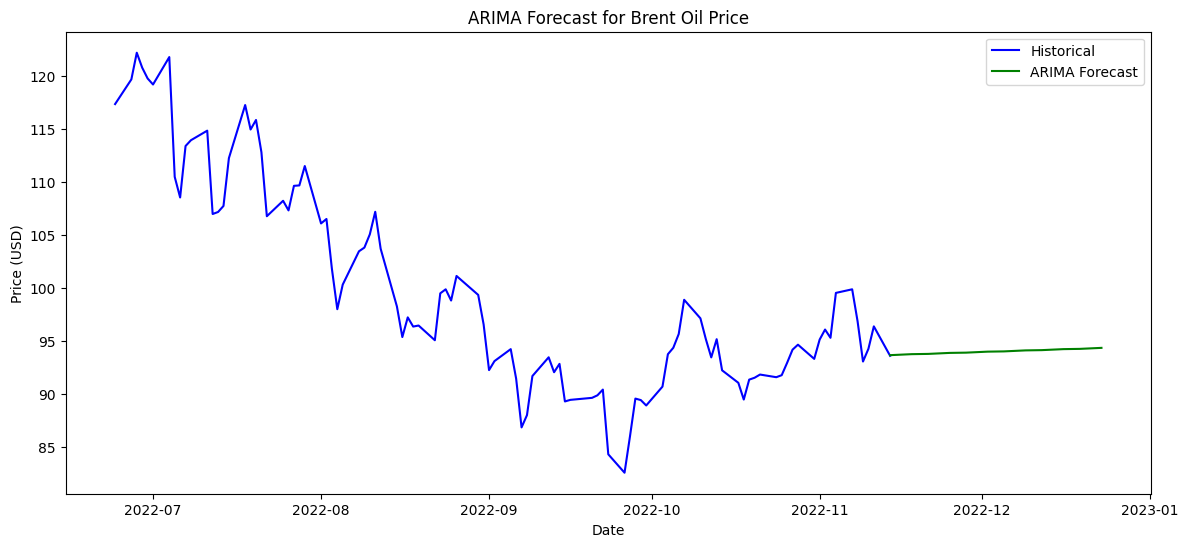

In [31]:
# Forecast future price using ARIMA
arima_forecast = arima_result.forecast(steps=30)
plt.figure(figsize=(14, 6))
plt.plot(data.index[-100:], data['Price'][-100:], color='blue', label='Historical')
plt.plot(pd.date_range(data.index[-1], periods=30, freq='B'), np.exp(arima_forecast.cumsum()) * data['Price'].iloc[-1], color='green', label='ARIMA Forecast')
plt.title("ARIMA Forecast for Brent Oil Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()